<a href="https://colab.research.google.com/github/sleepless-se/30nichideosjisaku/blob/master/image_maker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import google.colab
import keras
google.colab.drive.mount('/content/gdrive')

Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!git clone https://github.com/matterport/Mask_RCNN.git
%cd Mask_RCNN
!pip install -r requirements.txt
%run -i setup.py install
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!git clone https://github.com/waleedka/coco.git
%cd coco/PythonAPI
%run -i setup.py build_ext --inplace
%run -i setup.py build_ext install
%cd /content/Mask_RCNN

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
/content/Mask_RCNN


running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/config.py to config.cp

zip_safe flag not set; analyzing archive contents...


creating 'dist/mask_rcnn-2.1-py3.6.egg' and adding 'build/bdist.linux-x86_64/egg' to it
removing 'build/bdist.linux-x86_64/egg' (and everything under it)
Processing mask_rcnn-2.1-py3.6.egg
Removing /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Copying mask_rcnn-2.1-py3.6.egg to /usr/local/lib/python3.6/dist-packages
mask-rcnn 2.1 is already the active version in easy-install.pth

Installed /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Processing dependencies for mask-rcnn==2.1
Finished processing dependencies for mask-rcnn==2.1
--2019-05-30 08:06:18--  https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github-production-release-asset-2e65be.s3.amazonaws.com/107595270/872d3234-d21f-11e7-9a51-7b4bc8075835?X-Amz-Algorithm=AWS4-HMAC-SHA25

zip_safe flag not set; analyzing archive contents...
pycocotools.__pycache__._mask.cpython-36: module references __file__


creating 'dist/pycocotools-2.0-py3.6-linux-x86_64.egg' and adding 'build/bdist.linux-x86_64/egg' to it
removing 'build/bdist.linux-x86_64/egg' (and everything under it)
Processing pycocotools-2.0-py3.6-linux-x86_64.egg
removing '/usr/local/lib/python3.6/dist-packages/pycocotools-2.0-py3.6-linux-x86_64.egg' (and everything under it)
creating /usr/local/lib/python3.6/dist-packages/pycocotools-2.0-py3.6-linux-x86_64.egg
Extracting pycocotools-2.0-py3.6-linux-x86_64.egg to /usr/local/lib/python3.6/dist-packages
pycocotools 2.0 is already the active version in easy-install.pth

Installed /usr/local/lib/python3.6/dist-packages/pycocotools-2.0-py3.6-linux-x86_64.egg
Processing dependencies for pycocotools==2.0
Finished processing dependencies for pycocotools==2.0
/content/Mask_RCNN


In [3]:
!ls


assets	images	     mask_rcnn_coco.h5	  README.md	    setup.py
build	LICENSE      mask_rcnn_coco.h5.1  requirements.txt  temp.jpg
coco	MANIFEST.in  mask_rcnn.egg-info   samples
dist	Mask_RCNN    mrcnn		  setup.cfg


In [4]:
!python3 -V

Python 3.6.7


https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb

In [0]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from PIL import ImageFile, ImageChops
ImageFile.LOAD_TRUNCATED_IMAGES = True
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
# sys.path.append(os.path.join(ROOT_DIR, "coco/PythonAPI"))  # To find local version
# import coco
from samples.coco import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [6]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [7]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# 共通関数

In [0]:
from PIL import Image, ImageFilter, ImageDraw, ImageFont
import google.colab
import os

IMG_ROOT = '/content/gdrive/My Drive/data/fashon_item_images'
EDITED_IMG_ROOT = '/content/gdrive/My Drive/data/edited_images'


def show_results(results):
  # Visualize results
  r = results[0]
  print(r['rois'])
  print(r['class_ids'])
  print(r['scores'])

def resize(img,new_hight,rate=1):
  width,height = img.size
  rate =  new_hight / height
  new_width = width * rate 
  return img.resize((int(new_width),int(new_hight)),Image.LANCZOS)
  
def resize_to_target(img,new_size):
  short ,long = img.size
  if short < long:
    rate =  new_size / short
    new_height = long * rate 
    new_width = new_size
  else:
    rate =  new_size / long
    new_width = short * rate 
    new_height = new_size
  
  return img.resize((int(new_width),int(new_height)),Image.LANCZOS)

def get_center(img)->int:
  return int(img.size[0] / 2)

def shift_to(img_center,target_position)->int:
  gap = img_center - target_position
  shift = gap * -1
  print('shift',shift)
  return int(shift)  

def predict(image):
  array_image = keras.preprocessing.image.img_to_array(image)
  results = model.detect([array_image], verbose=1)
  return results

def get_object_center(image):
  results = predict(image)
  rois = results[0]['rois']
  height = image.size[0]
  width = image.size[1]
  x_center = width / 2
  y_center = height / 2
  top = 0
  left = 0 
  bottom =  height
  right = width

  max_area = 0
  for i in range(len(rois)):
#     print(rois[i])
    start_height = rois[i][0] 
    start_width = rois[i][1] 
    end_height = rois[i][2] 
    end_width = rois[i][3] 
    
    height = end_height - start_height
    width = end_width - start_width
    
    area = height * width
#     print('area',area)
    if area < max_area:continue
    max_area = area
    x_center = start_width + width / 2
    y_center = start_height + height / 2
    top = rois[i][0] 
    left = rois[i][1] 
    bottom = rois[i][2] 
    right = rois[i][3] 
#     print('update center',center)
  print('x,y',(int(x_center),int(y_center)),'left,top,right,bottom',left,top,right,bottom)
  return (int(x_center),int(y_center),left,top,right,bottom)



def to_RGB(image):
  if image.mode == 'RGB':return image
  image.load() # required for png.split()
  background = Image.new("RGB", image.size, (255, 255, 255))
  background.paste(image, mask=image.split()[3]) # 3 is the alpha channel
  return background
#   file_name = 'tmp.jpg'
#   background.save(file_name, 'JPEG', quality=80)
#   img = Image.open(file_name)
#   return img

def add_logo(image, logo:str):
  im = Image.open(logo)
  rgba_im = im.convert('RGBA')
  rgba_im = rgba_im.resize(image.size,Image.ANTIALIAS)
  image.paste(rgba_im,(0,0),mask=rgba_im.split()[3])
  return image


### 前処理　余白削除　シフト　ギャップ 

In [0]:
def open_rgb(image_path:str):
    im = Image.open(image_path)
    im = to_RGB(im)
    return im 

  

def remove_space(image:Image):
  # make background
  im2 = image.convert("RGB")
  bg = Image.new("RGB", im2.size, im2.getpixel((0, 0)))

  # make difference
  diff = ImageChops.difference(im2, bg)

  # remove space
  croprange = diff.convert("RGB").getbbox()
  nim = image.crop(croprange)
  nim.format = image.format
  return nim



In [0]:
test_images = []
test_images.append("/content/gdrive/My Drive/data/fashon_item_images/DE1CrawV0AEt_f2.jpg")
test_images.append("/content/gdrive/My Drive/data/fashon_item_images/428_6-214x300.jpg")
test_images.append("/content/gdrive/My Drive/data/fashon_item_images/left_image.jpg")
test_images.append("/content/gdrive/My Drive/data/fashon_item_images/right_image.jpg")
test_images.append("/content/gdrive/My Drive/data/fashon_item_images/org-28.jpg")
test_images.append("/content/gdrive/My Drive/data/fashon_item_images/org-29.jpg")
test_images.append("/content/gdrive/My Drive/data/fashon_item_images/org-53.jpg")
test_images.append("/content/gdrive/My Drive/data/fashon_item_images/org-54.jpg")
test_images.append("/content/gdrive/My Drive/data/fashon_item_images/org-55.jpg")


# 左右1:2

i 0
Processing 1 images
image                    shape: (600, 806, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.31999  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
x,y (487, 304) left,top,right,bottom 406 16 569 592
Processing 1 images
image                    shape: (600, 428, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.88214  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
x,y (298, 296) left,top,right,bottom 219 16 378 577
shift -387
shift 102
image1_gap -206
image2_gap 172
x1_shift -387
x2_shift 172
im2_m

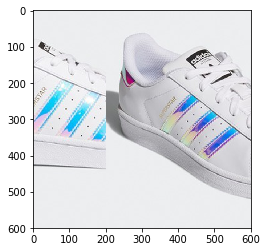

In [35]:

import matplotlib.pyplot as plt

# img_path = '/content/gdrive/My Drive/data/fashon_item_images/right_image.jpg'
# img_path2 = '/content/gdrive/My Drive/data/fashon_item_images/left_image.jpg'

# img_path = '/content/gdrive/My Drive/data/fashon_item_images/org-28.jpg'
# img_path2 = '/content/gdrive/My Drive/data/fashon_item_images/org-29.jpg'

logo = '/content/gdrive/My Drive/img/logo/reinbow_1.png'
canvas_size = 500





def split1_2(img_path,img_path2,canvas_size = 500):
  
  im1 = open_rgb(img_path)
  im2 = open_rgb(img_path2)
  
  # remove speace
  im1 = remove_space(im1)
  im2 = remove_space(im2)
  
  # resize
  im1 = resize(im1,canvas_size)
  im2 = resize(im2,canvas_size)
  
  # get image center
  img1_center = get_object_center(im1)
  img2_center = get_object_center(im2)

  # call target position  
  target1 = int(canvas_size/ 6 *1)
  target2 = int(canvas_size/ 6 *4)

  # call space of canvas
  image1_gap = canvas_size - im1.size[0] 
  image2_gap = canvas_size - im2.size[0]
  
  # get shift px
  x1_shift = shift_to(img1_center[0],target1)
  x2_shift = shift_to(img2_center[0],target2)
  
  # shift condition
  if x1_shift > 0:x1_shift = 0
  if x2_shift < image2_gap:x2_shift = image2_gap
  if x2_shift > canvas_size / 2:x2_shift = canvas_size / 2

  # mask condition
  im2_mask_left = canvas_size / 3 - x2_shift
  if im2_mask_left < 0:im2_mask_left = 0
    
  # make mask
  mask2 = Image.new("L",im2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((im2_mask_left, 0, im2.size), fill=255)

  # merge images
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  bg.paste(im1,(x1_shift,0))
  bg.paste(im2,(x2_shift,0),mask2)

  print('image1_gap',image1_gap)
  print('image2_gap',image2_gap)
  print('x1_shift',x1_shift)
  print('x2_shift',x2_shift)
  print('im2_mask_left',im2_mask_left)

  return bg

images = os.listdir(IMG_ROOT)

for i in range(len(test_images)-1):
  print('i',i)
  file_name = f'split1_2_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  img_path = os.path.join(IMG_ROOT, test_images[i])
  img_path2 = os.path.join(IMG_ROOT, test_images[i+1])
  bg = split1_2(img_path,img_path2,600)
#   bg = add_logo(bg,logo)
  bg.save(save_file_path)
#   break
  
plt.imshow(bg)

In [28]:
bg.resize([200,200],Image.ANTIALIAS)
bg.split()

(<PIL.Image.Image image mode=L size=600x600 at 0x7F9AD071E358>,
 <PIL.Image.Image image mode=L size=600x600 at 0x7F9AD071EB38>,
 <PIL.Image.Image image mode=L size=600x600 at 0x7F9AD0729F98>)

(<PIL.Image.Image image mode=L size=600x600 at 0x7F9960937BE0>,
 <PIL.Image.Image image mode=L size=600x600 at 0x7F9960937E10>,
 <PIL.Image.Image image mode=L size=600x600 at 0x7F9960937978>)

In [0]:
bg.save('temp.jpg')

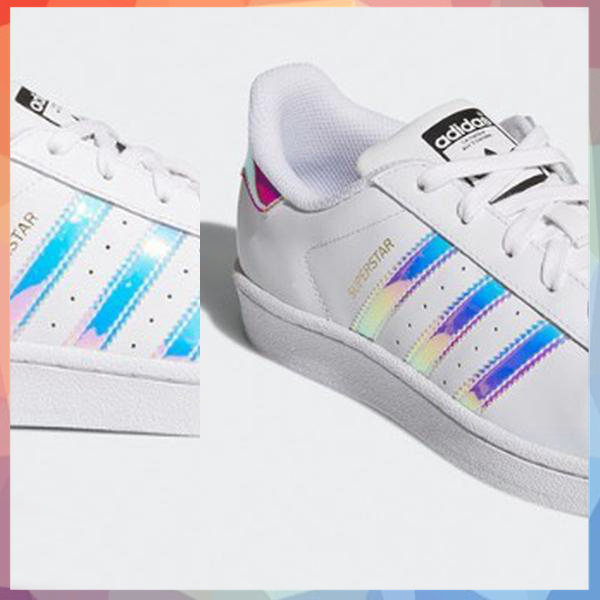

In [42]:
bg = Image.open('temp.jpg')
im = Image.open(logo)
rgba_im = im.convert('RGBA')
rgba_im = rgba_im.resize(bg.size,Image.ANTIALIAS)
bg.paste(rgba_im,(0,0),mask=rgba_im.split()[3])
bg
# bak
# bg

# 真ん中正方形

In [0]:
def square_image(img_path,canvas_size = 500):
  im = open_rgb(img_path)
  im = to_RGB(im)
  im = remove_space(im)
  im = resize(im,canvas_size)
  img_center = get_object_center(im)
  img_corner = img_center[2:]
  print('img_corner',img_corner)
  width = img_corner[2] - img_corner[0] 
  height = img_corner[3] - img_corner[1]
  length = width
  if width < height:length = height
  print('fit longer length',length)

  x_shift = shift_to(img_center[0],int(length/2))
  y_shift = shift_to(img_center[1],int(length/2))

  bg = Image.new("RGB",(length,length),(250,250,250))
  bg.paste(im,(x_shift, y_shift))
  resized_img = resize(bg,canvas_size)
  return resized_img

Processing 1 images
image                    shape: (500, 391, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.92750  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
x,y (151, 250) left,top,right,bottom 8 0 295 500
img_corner (8, 0, 295, 500)
fit longer length 500
shift 99
shift 0


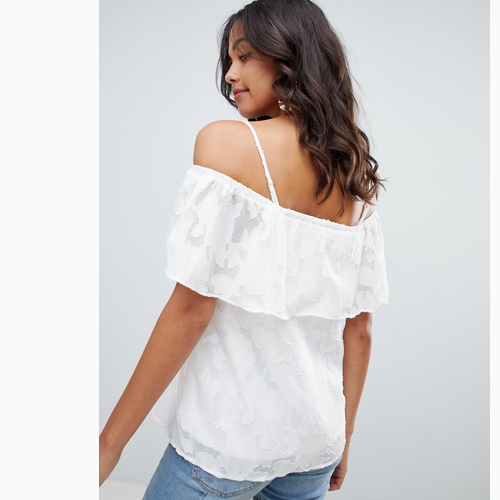

In [55]:
square_image(test_images[2])

In [0]:
images = os.listdir(IMG_ROOT)
for i in range(len(test_images)):
  print('i',i)
  file_name = f'square_image_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  img_path = os.path.join(IMG_ROOT, test_images[i])
  print('img_path',img_path)
  bg = square_image(img_path,500)
  bg.save(save_file_path)
bg

# 左右の画像加工

In [0]:
def split1_1(left_img_path,right_img_path,  canvas_size = 500):
  im1 = open_rgb(img_path)
  im2 = open_rgb(img_path2)
  
  # remove speace
  im1 = remove_space(im1)
  im2 = remove_space(im2)
  
  # resize
  im1 = resize(im1,canvas_size)
  im2 = resize(im2,canvas_size)
  
  # get image center
  img1_center = get_object_center(im1)
  img2_center = get_object_center(im2)

  # call target position  
  target1 = int(canvas_size/ 4 * 1)
  target2 = int(canvas_size/ 4 * 3)

  # call space of canvas
  image1_gap = canvas_size - im1.size[0] 
  image2_gap = canvas_size - im2.size[0]
  
  # shift image
  x1_shift = shift_to(img1_center[0],target1)
  x2_shift = shift_to(img2_center[0],target2)
  
  # shift condition
  if x1_shift > 0:x1_shift = 0
  if x1_shift < -1 * (im1.size[0] - canvas_size / 2 ):x1_shift = int(-1 * (im1.size[0] - canvas_size / 2))
  if x2_shift < image2_gap:x2_shift = image2_gap
  if x2_shift > canvas_size / 2:x2_shift = canvas_size / 2

  # mask condition
  im2_mask_left = canvas_size / 2 - x2_shift
  if im2_mask_left < 0:im2_mask_left = 0
    
  # make mask
  mask2 = Image.new("L",im2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((im2_mask_left, 0, im2.size), fill=255)

  # merge images
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  bg.paste(im1,(x1_shift,0))
  bg.paste(im2,(x2_shift,0),mask2)

  print('image1_gap',image1_gap)
  print('image2_gap',image2_gap)
  print('x1_shift',x1_shift)
  print('x2_shift',x2_shift)
  print('im2_mask_left',im2_mask_left)

  return bg

images = os.listdir(IMG_ROOT)

for i in range(len(test_images)-1):
  print('i',i)
  file_name = f'split1_1_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  img_path = os.path.join(IMG_ROOT, test_images[i])
  img_path2 = os.path.join(IMG_ROOT, test_images[i+1])
  bg = split1_1(img_path,img_path2,600)
#   bg = add_logo(bg,logo)
  bg.save(save_file_path)
#   break
  
plt.imshow(bg)


# 3枚 画像加工

In [0]:
def left1_right2(left_img_path,right_up_img_path,right_down_img_path,  canvas_size = 500):
 
  
 
  
  # load image
  im1 = open_rgb(left_img_path)
  im2 = open_rgb(right_up_img_path)
  im3 = open_rgb(right_down_img_path)
  
  # remove space
  im1 = remove_space(im1)
  im2 = remove_space(im2)
  im3 = remove_space(im3)
  
  # resize image   
  im1 = resize(im1,canvas_size)
  im2 = resize_to_target(im2,canvas_size/20*10)
  im3 = resize_to_target(im3,canvas_size/20*10)
  
  # get object centor
  im1_center = get_object_center(im1)
  im2_center = get_object_center(im2)
  im3_center = get_object_center(im3)
  
  # target position
  target1 = int(canvas_size / 10 * 3)
  target2 = int(canvas_size /10 * 8)
  
  # shift image
  print(im1_center[0],target1)
  x1_shift = shift_to(im1_center[0],target1)
  x2_shift = shift_to(im2_center[0],target2)
  x2_shift = shift_to(im3_center[0],target2)
  
  # image gap of canvas size
  image2_gap = int(im2.size[0] - canvas_size / 10 * 4)
  
  # shift condition
  if x1_shift > 0:x1_shift = 0
  if x1_shift < -1 * (im1.size[0] - canvas_size / 2 ):x1_shift = int(-1 * (im1.size[0] - canvas_size / 2))
  if x2_shift < image2_gap:x2_shift = image2_gap
  if x2_shift > canvas_size / 2:x2_shift = int(canvas_size / 2)

  # mask condition
  im2_mask_left = canvas_size / 2 - x2_shift
  if im2_mask_left < 0:im2_mask_left = 0

  # make mask 
  mask2 = Image.new("L",im2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((image2_gap ,0, im2.size[0], canvas_size/2), fill=255)
  mask3 = Image.new("L",im3.size,0)
  draw3 = ImageDraw.Draw(mask3)
  draw3.rectangle((image2_gap ,0, im3.size[0], im3.size[1]), fill=255)
  
#   print('image1_gap',image1_gap)
  print('image2_gap',image2_gap)
  print('x1_shift',x1_shift)
  print('x2_shift',x2_shift)
  print('im2_mask_left',im2_mask_left)

  
  # composite image 
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  bg.paste(im1,(x1_shift,0))
  bg.paste(im2,(x2_shift,0),mask2)
  bg.paste(im3,(x2_shift,int(canvas_size/2)),mask3)
  return bg



/content/gdrive/My Drive/data/fashon_item_images/DE1CrawV0AEt_f2.jpg
Processing 1 images
image                    shape: (500, 671, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.55914  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
x,y (405, 253) left,top,right,bottom 338 14 473 492
Processing 1 images
image                    shape: (350, 250, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.91448  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
x,y (176, 174) left,top,right,bottom 131 10 221 339
Processing 1 images

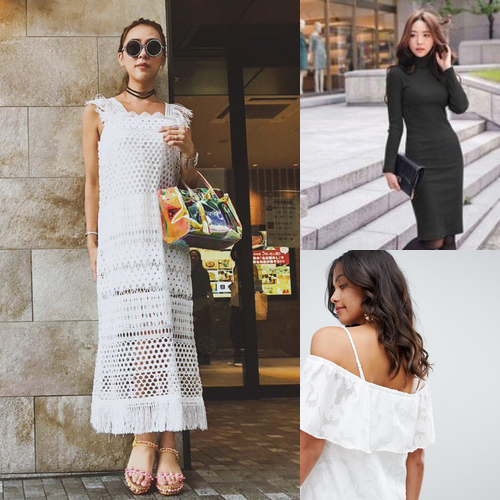

In [41]:
# images = os.listdir(IMG_ROOT)
for i in range(len(test_images)): 
  print(test_images[i])
  bg = left1_right2(test_images[i],test_images[i+1],test_images[i+2],  canvas_size = 500)
  file_name = f'left1_right2_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
  break
bg  


# 横3枚の画像加工

In [0]:
def left_middle_right_image(left_img_path,middle_img_path,right_img_path,  canvas_size = 500):
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # load image
  im1 = Image.open(left_img_path)
  im2 = Image.open(middle_img_path)
  im3 = Image.open(right_img_path)
  
  im1 = to_RGB(im1)
  im2 = to_RGB(im2)
  im3 = to_RGB(im3)  
  # resize image   
  rim1 = resize(im1,canvas_size)
  rim2 = resize(im2,canvas_size)
  rim3 = resize(im3,canvas_size)
  
  # get object centor
  rim1_center = get_object_center(rim1)[0]
  rim2_center = get_object_center(rim2)[0]
  rim3_center = get_object_center(rim3)[0]
#   print('left_img_object_centor',iml2_center)
#   print('right_img_object_centor',imr2_center)

  # make mask
  mask_width = canvas_size / 3
  mask1 = Image.new("L",rim1.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((rim1_center - mask_width / 2, 0, canvas_size, canvas_size), fill=255)
  mask2 = Image.new("L",rim2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((rim2_center - mask_width / 2 ,0, rim2_center+ mask_width / 2, canvas_size), fill=255)
  mask3 = Image.new("L",rim3.size,0)
  draw3 = ImageDraw.Draw(mask3)
  draw3.rectangle((rim3_center - mask_width / 2 ,0, rim3_center+ mask_width / 2, canvas_size), fill=255)

  # target position
  left_target = int(canvas_size / 6 * 1)
  middle_target = int(canvas_size / 6 * 3)
  right_target = int(canvas_size / 6 * 5)
  
  # composite image 
  bg.paste(rim1,(shift_to(rim1_center,left_target),0),mask1)
  bg.paste(rim2,(shift_to(rim2_center,middle_target),0),mask2)
  bg.paste(rim3,(shift_to(rim3_center,right_target),0),mask3)
  return bg

In [0]:
images = os.listdir(IMG_ROOT)
for i in range(49,len(images)-3):
  left_img_path = os.path.join(IMG_ROOT, images[i])
  middle_img_path = os.path.join(IMG_ROOT, images[i+1])
  right_img_path = os.path.join(IMG_ROOT, images[i+2])
  
  print('left_img_path',left_img_path)
  print('middle_img_path',middle_img_path)
  print('right_img_path',right_img_path)

  bg = left_middle_right_image(left_img_path,middle_img_path,right_img_path,  canvas_size = 500)
  file_name = f'3line_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
  saved_image = Image.open(save_file_path)
  break
saved_image
  

# 縦4枚の画像加工

In [0]:
def split_4line_image(img1_path, img2_path, img3_path, img4_path, canvas_size = 500):
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # load image
  im1 = Image.open(img1_path)
  im2 = Image.open(img2_path)
  im3 = Image.open(img3_path)
  im4 = Image.open(img4_path)
  
  im1 = to_RGB(im1)
  im2 = to_RGB(im2)
  im3 = to_RGB(im3)  
  im4 = to_RGB(im4)  
  # resize image   
  rim1 = resize(im1,canvas_size)
  rim2 = resize(im2,canvas_size)
  rim3 = resize(im3,canvas_size)
  rim4 = resize(im4,canvas_size)
  
  # get object centor
  rim1_center = get_object_center(rim1)[0]
  rim2_center = get_object_center(rim2)[0]
  rim3_center = get_object_center(rim3)[0]
  rim4_center = get_object_center(rim4)[0]

  # make mask
  mask_width = canvas_size / 4
  mask1 = Image.new("L",rim1.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((rim1_center - mask_width / 2, 0, canvas_size, canvas_size), fill=255)
  mask2 = Image.new("L",rim2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((rim2_center - mask_width / 2 ,0, canvas_size, canvas_size), fill=255)
  mask3 = Image.new("L",rim3.size,0)
  draw3 = ImageDraw.Draw(mask3)
  draw3.rectangle((rim3_center - mask_width / 2 ,0, canvas_size, canvas_size), fill=255)
  mask4 = Image.new("L",rim4.size,0)
  draw4 = ImageDraw.Draw(mask4)
  draw4.rectangle((rim4_center - mask_width / 2 ,0, canvas_size, canvas_size), fill=255)

  # target position
  target_1 = int(canvas_size / 8 * 1)
  target_2 = int(canvas_size / 8 * 3)
  target_3 = int(canvas_size / 8 * 5)
  target_4 = int(canvas_size / 8 * 7)
  
  print(target_1,target_2,target_3,target_4)
  
  # composite image 
  bg.paste(rim1,(shift_to(rim1_center,target_1),0),mask1)
  bg.paste(rim2,(shift_to(rim2_center,target_2),0),mask2)
  bg.paste(rim3,(shift_to(rim3_center,target_3),0),mask3)
  bg.paste(rim4,(shift_to(rim4_center,target_4),0),mask4)
  return bg

In [0]:
images = os.listdir(IMG_ROOT)
for i in range(52,len(images)-4,4):
  image_1 = os.path.join(IMG_ROOT, images[i])
  image_2 = os.path.join(IMG_ROOT, images[i+1])
  image_3 = os.path.join(IMG_ROOT, images[i+2])
  image_4 = os.path.join(IMG_ROOT, images[i+3])
  
  print('image_1',image_1)
  print('image_2',image_2)
  print('image_3',image_3)
  print('image_4',image_4)

  bg = split_4line_image(image_1,image_2,image_3,image_4,  canvas_size = 500)
  file_name = f'4line_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
  saved_image = Image.open(save_file_path)
  break
saved_image


# 正方形4面


In [0]:
def square_4image(img1_path, img2_path, img3_path, img4_path, canvas_size = 500):
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # load image
  im1 = Image.open(img1_path)
  im2 = Image.open(img2_path)
  im3 = Image.open(img3_path)
  im4 = Image.open(img4_path)
  
  im1 = to_RGB(im1)
  im2 = to_RGB(im2)
  im3 = to_RGB(im3)  
  im4 = to_RGB(im4)  
  # resize image   
#   rim1 = resize(im1,canvas_size/2)
#   rim2 = resize(im2,canvas_size/2)
#   rim3 = resize(im3,canvas_size/2)
#   rim4 = resize(im4,canvas_size/2)  
  
  rim1 = resize_to_target(im1,canvas_size/2)
  rim2 = resize_to_target(im2,canvas_size/2)
  rim3 = resize_to_target(im3,canvas_size/2)
  rim4 = resize_to_target(im4,canvas_size/2)
  
  # get object centor
  rim1_center = get_object_center(rim1)
  rim2_center = get_object_center(rim2)
  rim3_center = get_object_center(rim3)
  rim4_center = get_object_center(rim4)

  mask_width = canvas_size / 2
  
  
  # target position
  target_1 = int(canvas_size / 4 * 1)
  target_2 = int(canvas_size / 4 * 3)
  target_3 = int(canvas_size / 4 * 1)
  target_4 = int(canvas_size / 4 * 3)
  
  # make mask
  mask1 = Image.new("L",rim1.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((rim1_center[0] - mask_width, 0, rim1_center[0] + mask_width /2 , canvas_size/2), fill=255)
  mask2 = Image.new("L",rim2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((rim2_center[0] - mask_width / 2,0, canvas_size, canvas_size/2), fill=255)
  mask3 = Image.new("L",rim3.size,0)
  draw3 = ImageDraw.Draw(mask3)
  draw3.rectangle((rim3_center[0] - mask_width ,0, rim3_center[0] + mask_width /2, canvas_size), fill=255)
  mask4 = Image.new("L",rim4.size,0)
  draw4 = ImageDraw.Draw(mask4)
  draw4.rectangle((rim4_center[0] - mask_width / 2 ,0, canvas_size, canvas_size), fill=255)


  
  print(target_1,target_2,target_3,target_4)
  
  # composite image 
  bg.paste(rim1,(shift_to(rim1_center[0],target_1),0),mask1)
  bg.paste(rim2,(shift_to(rim2_center[0],target_2),0),mask2)
  bg.paste(rim3,(shift_to(rim3_center[0],target_3),int(canvas_size / 2)),mask3)
  bg.paste(rim4,(shift_to(rim4_center[0],target_4),int(canvas_size / 2)),mask4)
  return bg
i = 94
image_1 = os.path.join(IMG_ROOT, images[i])
image_2 = os.path.join(IMG_ROOT, images[i+1])
image_3 = os.path.join(IMG_ROOT, images[i+2])
image_4 = os.path.join(IMG_ROOT, images[i+3])
square_4image(image_1,image_2,image_3,image_4,  canvas_size = 500)

In [0]:
images = os.listdir(IMG_ROOT)


for i in range(0,len(images)-4,8):
  image_1 = os.path.join(IMG_ROOT, images[i])
  image_2 = os.path.join(IMG_ROOT, images[i+1])
  image_3 = os.path.join(IMG_ROOT, images[i+2])
  image_4 = os.path.join(IMG_ROOT, images[i+3])
  
  print('image_1',image_1)
  print('image_2',image_2)
  print('image_3',image_3)
  print('image_4',image_4)

  bg = square_4image(image_1,image_2,image_3,image_4,  canvas_size = 500)
  file_name = f'4square_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
  saved_image = Image.open(save_file_path)
  if i == 10:break
saved_image

## 上1 下2 

In [0]:
def upper1_lower2_image(img1_path, img2_path, img3_path, canvas_size = 500):
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # load image
  im1 = Image.open(img1_path)
  im2 = Image.open(img2_path)
  im3 = Image.open(img3_path)
  
  im1 = to_RGB(im1)
  im2 = to_RGB(im2)
  im3 = to_RGB(im3)  

  # resize image   
  rim1 = resize_to_target(im1,canvas_size)
  rim2 = resize_to_target(im2,canvas_size/2)
  rim3 = resize_to_target(im3,canvas_size/2)
  
  # get object centor
  rim1_center = get_object_center(rim1)
  rim2_center = get_object_center(rim2)
  rim3_center = get_object_center(rim3)

  # make mask
  mask_width = canvas_size
  mask1 = Image.new("L",rim1.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((0, rim1_center[1] - mask_width / 2, canvas_size, rim1_center[1] + mask_width / 2), fill=255)
  
  mask2 = Image.new("L",rim2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((0 ,0, canvas_size, canvas_size), fill=255)
  
  mask3 = Image.new("L",rim3.size,0)
  draw3 = ImageDraw.Draw(mask3)
  draw3.rectangle((rim3_center[0] - mask_width / 2 ,0, canvas_size, canvas_size), fill=255)
  
  # target position
  target_x_1 = int(canvas_size / 2)
  target_x_3 = int(canvas_size / 4 * 3)
  target_y_2 = int(canvas_size / 4 * 3)
  target_y_3 = int(canvas_size / 4 * 3)
  
  print(target_x_1,target_x_3)
  print(target_y_2,target_y_3)
  
  # composite image 
  bg.paste(rim2,(0,shift_to(rim2_center[1],target_y_2)),mask2)
  bg.paste(rim3,(shift_to(rim3_center[0],target_x_3),shift_to(rim3_center[1],target_y_3)),mask3)
  bg.paste(rim1,(shift_to(rim1_center[0],target_x_1),shift_to(rim1_center[1],0)),mask1)
  return bg


i=33
image_1 = os.path.join(IMG_ROOT, images[i])
image_2 = os.path.join(IMG_ROOT, images[i+1])
image_3 = os.path.join(IMG_ROOT, images[i+2])

bg = upper1_lower2_image(image_1,image_2,image_3,  canvas_size = 500)
file_name = f'u1_l2_{i}.png'
save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
bg.save(save_file_path)
saved_image = Image.open(save_file_path)
saved_image

In [0]:
images = os.listdir(IMG_ROOT)
for i in range(0,len(images)-1,3):
  image_1 = os.path.join(IMG_ROOT, images[i])
  image_2 = os.path.join(IMG_ROOT, images[i+1])
  image_3 = os.path.join(IMG_ROOT, images[i+2])
  
  print('image_1',image_1)
  print('image_2',image_2)

  bg = upper1_lower2_image(image_1,image_2,image_3,  canvas_size = 500)
  file_name = f'u1_l2_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
  saved_image = Image.open(save_file_path)
  if i == 10:break
#   break
saved_image

## 上2 下1

In [0]:
def upper1_lower2_image(img1_path, img2_path, img3_path, canvas_size = 500):
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # load image
  im1 = Image.open(img1_path)
  im2 = Image.open(img2_path)
  im3 = Image.open(img3_path)
  
  im1 = to_RGB(im1)
  im2 = to_RGB(im2)
  im3 = to_RGB(im3)  

  # resize image   
  rim1 = resize_to_target(im1,canvas_size/2)
  rim2 = resize_to_target(im2,canvas_size/2)
  rim3 = resize_to_target(im3,canvas_size)
  
  # get object centor
  rim1_center = get_object_center(rim1)
  rim2_center = get_object_center(rim2)
  rim3_center = get_object_center(rim3)

  # make mask
  mask_width = canvas_size / 2
  mask1 = Image.new("L",rim1.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((0, rim1_center[1] - mask_width, rim1_center[0] + mask_width, rim1_center[1] + mask_width), fill=255)
  
  mask2 = Image.new("L",rim2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((rim2_center[0] - mask_width ,0, rim2_center[0] + mask_width, rim2_center[1] + mask_width), fill=255)
  
  mask3 = Image.new("L",rim3.size,0)
  draw3 = ImageDraw.Draw(mask3)
  draw3.rectangle((0 ,rim3_center[1] - mask_width, canvas_size, rim3_center[1] + mask_width), fill=255)
  
  # target position
  target_x_1 = int(canvas_size / 4 * 1)
  target_x_2 = int(canvas_size / 4 * 3)
  target_y_1 = int(canvas_size / 4 * 1)
  target_y_2 = int(canvas_size / 4 * 1)
  
  print(target_x_1,target_x_2)
  print(target_y_1,target_y_2,target_y_3)
  
  # composite image 
  bg.paste(rim1,(shift_to(rim1_center[0],target_x_1),shift_to(rim1_center[1],target_y_1)),mask1)
  bg.paste(rim2,(shift_to(rim2_center[0],target_x_2),shift_to(rim2_center[1],target_y_2)),mask2)
  bg.paste(rim3,(0,shift_to(rim3_center[1],canvas_size)),mask3)
  return bg


i=90
image_1 = os.path.join(IMG_ROOT, images[i])
image_2 = os.path.join(IMG_ROOT, images[i+1])
image_3 = os.path.join(IMG_ROOT, images[i+2])

bg = upper1_lower2_image(image_1,image_2,image_3,  canvas_size = 500)
file_name = f'u1_l2_{i}.png'
save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
bg.save(save_file_path)
saved_image = Image.open(save_file_path)
saved_image

In [0]:
images = os.listdir(IMG_ROOT)
for i in range(0,len(images)-1,3):
  image_1 = os.path.join(IMG_ROOT, images[i])
  image_2 = os.path.join(IMG_ROOT, images[i+1])
  image_3 = os.path.join(IMG_ROOT, images[i+2])
  
  print('image_1',image_1)
  print('image_2',image_2)

  bg = upper1_lower2_image(image_1,image_2,image_3,  canvas_size = 500)
  file_name = f'u2_l1_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
  saved_image = Image.open(save_file_path)
#   if i == 10:break
#   break
saved_image

# 左右1:2 

In [0]:
def split1_2(left_img_path,right_img_path,  canvas_size = 500):
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # load image
  im1 = Image.open(left_img_path)
  im3 = Image.open(right_img_path)
  
  im1 = to_RGB(im1)
  im3 = to_RGB(im3)  
  # resize image   
  rim1 = resize(im1,canvas_size)
  rim3 = resize(im3,canvas_size)
  
  # get object centor
  rim1_center = get_object_center(rim1)
  rim3_center = get_object_center(rim3)
#   print('left_img_object_centor',iml2_center)
#   print('right_img_object_centor',imr2_center)
  
  # target position
  left_target = int(canvas_size / 6 * 1)
  right_target = int(canvas_size / 6 * 4)

  shift1 = shift_to(rim1_center,left_target)
  shift3 = shift_to(rim3_center,right_target)
  mask_edge = rim1_center + left_target
  print('mask edge',mask_edge)
  print('1/3',canvas_size / 3)
  # make mask
  mask_width = canvas_size / 3 * 2
  mask1 = Image.new("L",rim1.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((0, 0, mask_edge, canvas_size), fill=255)

  # composite image 
  bg.paste(rim3,(shift3,0))
  bg.paste(rim1,(shift1,0),mask1)
  return bg

In [0]:
images = os.listdir(IMG_ROOT)
i = 11
for i in range(0,len(images)-1):
  left_img_path = os.path.join(IMG_ROOT, images[i])
  right_img_path = os.path.join(IMG_ROOT, images[i+1])
  
  print('left_img_path',left_img_path)
  print('right_img_path',right_img_path)

  bg = split1_2(left_img_path,right_img_path,  canvas_size = 500)
  file_name = f'split1_2_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
saved_image = Image.open(save_file_path)
saved_image
  